# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from math import * 
from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from   sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    AdaBoostClassifier, 
    ExtraTreesClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from pycaret.classification import ClassificationExperiment



# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/train.csv')
data = data.drop_duplicates()
data

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


# 3. Initial Analysis

### 3.1. Metadata

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   int8   
 1   duration                1000 non-null   float32
 2   credit_history          1000 non-null   int8   
 3   purpose                 1000 non-null   int8   
 4   credit_amount           1000 non-null   float32
 5   savings_status          1000 non-null   int8   
 6   employment              1000 non-null   int8   
 7   installment_commitment  1000 non-null   float32
 8   personal_status         1000 non-null   int8   
 9   other_parties           1000 non-null   int8   
 10  residence_since         1000 non-null   float32
 11  property_magnitude      1000 non-null   int8   
 12  age                     1000 non-null   float32
 13  other_payment_plans     1000 non-null   int8   
 14  housing                 1000 non-null   i

In [5]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_commitment,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [6]:
print(f'Number of duplicates data : {data.duplicated().sum()}')
print(f'Number of null data       : {data.isnull().sum().sum()}')

Number of duplicates data : 0
Number of null data       : 0


In [7]:
no_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/no_of_columns
print(round(percentage_of_missing_data*100), 2)

checking_status           0.0
duration                  0.0
credit_history            0.0
purpose                   0.0
credit_amount             0.0
savings_status            0.0
employment                0.0
installment_commitment    0.0
personal_status           0.0
other_parties             0.0
residence_since           0.0
property_magnitude        0.0
age                       0.0
other_payment_plans       0.0
housing                   0.0
existing_credits          0.0
job                       0.0
num_dependents            0.0
own_telephone             0.0
foreign_worker            0.0
class                     0.0
dtype: float64 2


In [8]:
data.nunique()

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
other_payment_plans         3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
foreign_worker              2
class                       2
dtype: int64

### 3.2. Columns Processing

In [4]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']

print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']
Categorical Columns : []


In [10]:
def impute_nan(data):
    for col in numerical_columns:
        data[col] = data[col].fillna(data[col].mean())

    for col in categorical_columns:
        data[col] = data[col].fillna(data[col].value_counts().index[0])
impute_nan(data)

In [ ]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()

    for column in categorical_columns:
        data[column] = LE.fit_transform(data[column])
        # data[column] = data[column].apply(pd.to_numeric, downcast='integer')
        print(f'{column} : {LE.classes_}') 

change_columns_to_numerical(data)

In [5]:
def downcasting_dtypes(data):
    fcols = data.select_dtypes('float').columns
    icols = data.select_dtypes('integer').columns

    data[fcols] = data[fcols].apply(pd.to_numeric, downcast='float')
    data[icols] = data[icols].apply(pd.to_numeric, downcast='integer')

downcasting_dtypes(data)

### 3.3. EDA

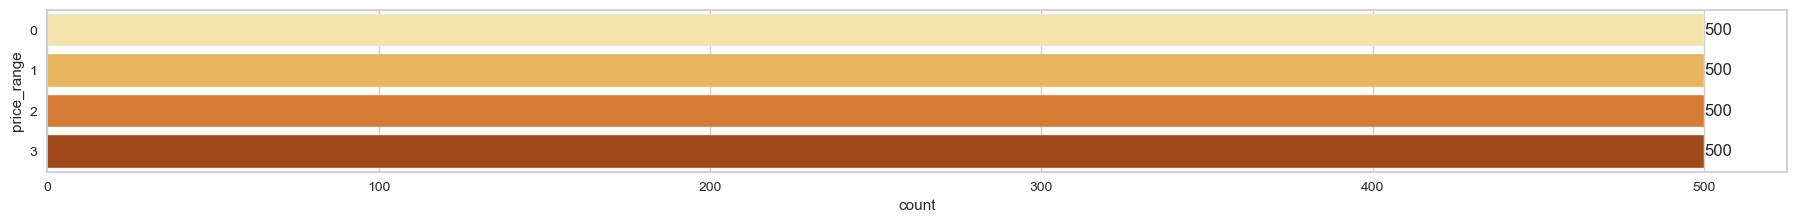

In [6]:
plt.subplots(figsize = (20,2))
ax = sns.countplot(data = data, y = 'price_range', palette='YlOrBr')
ax.bar_label(ax.containers[0])
plt.show()

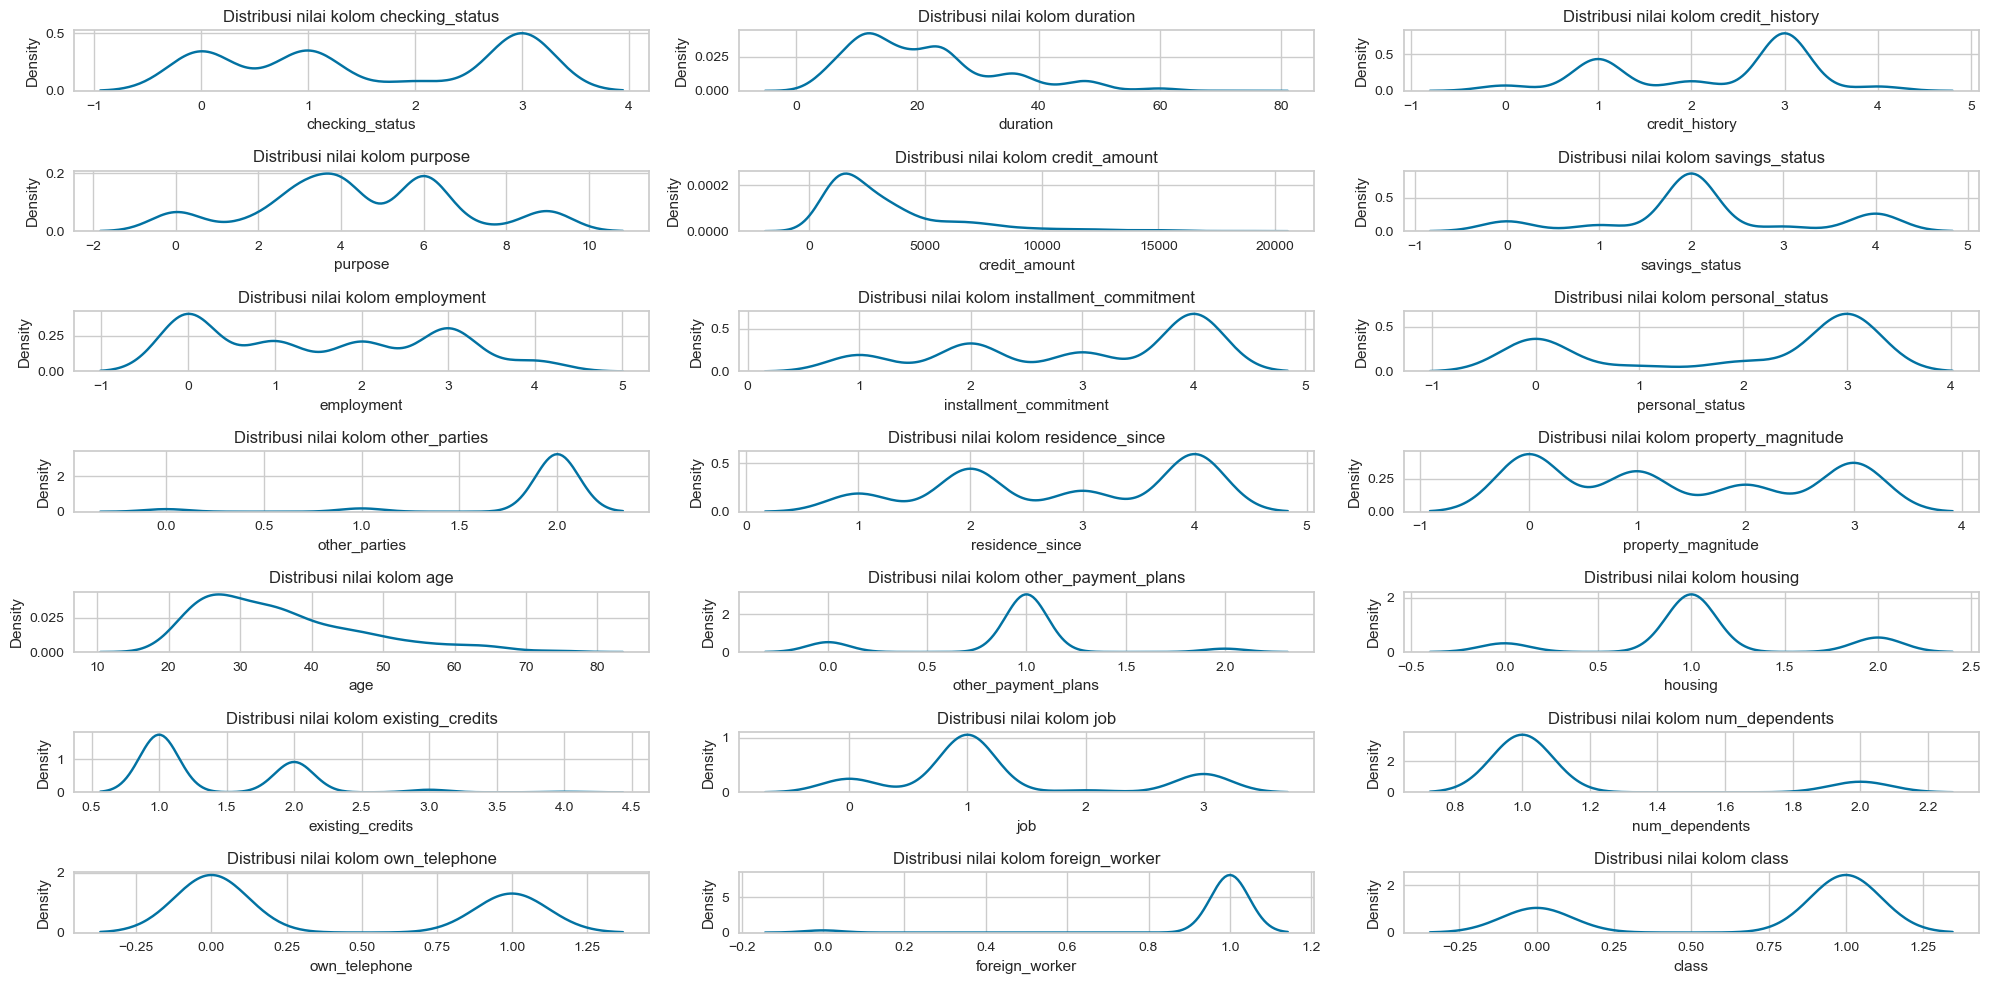

In [18]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

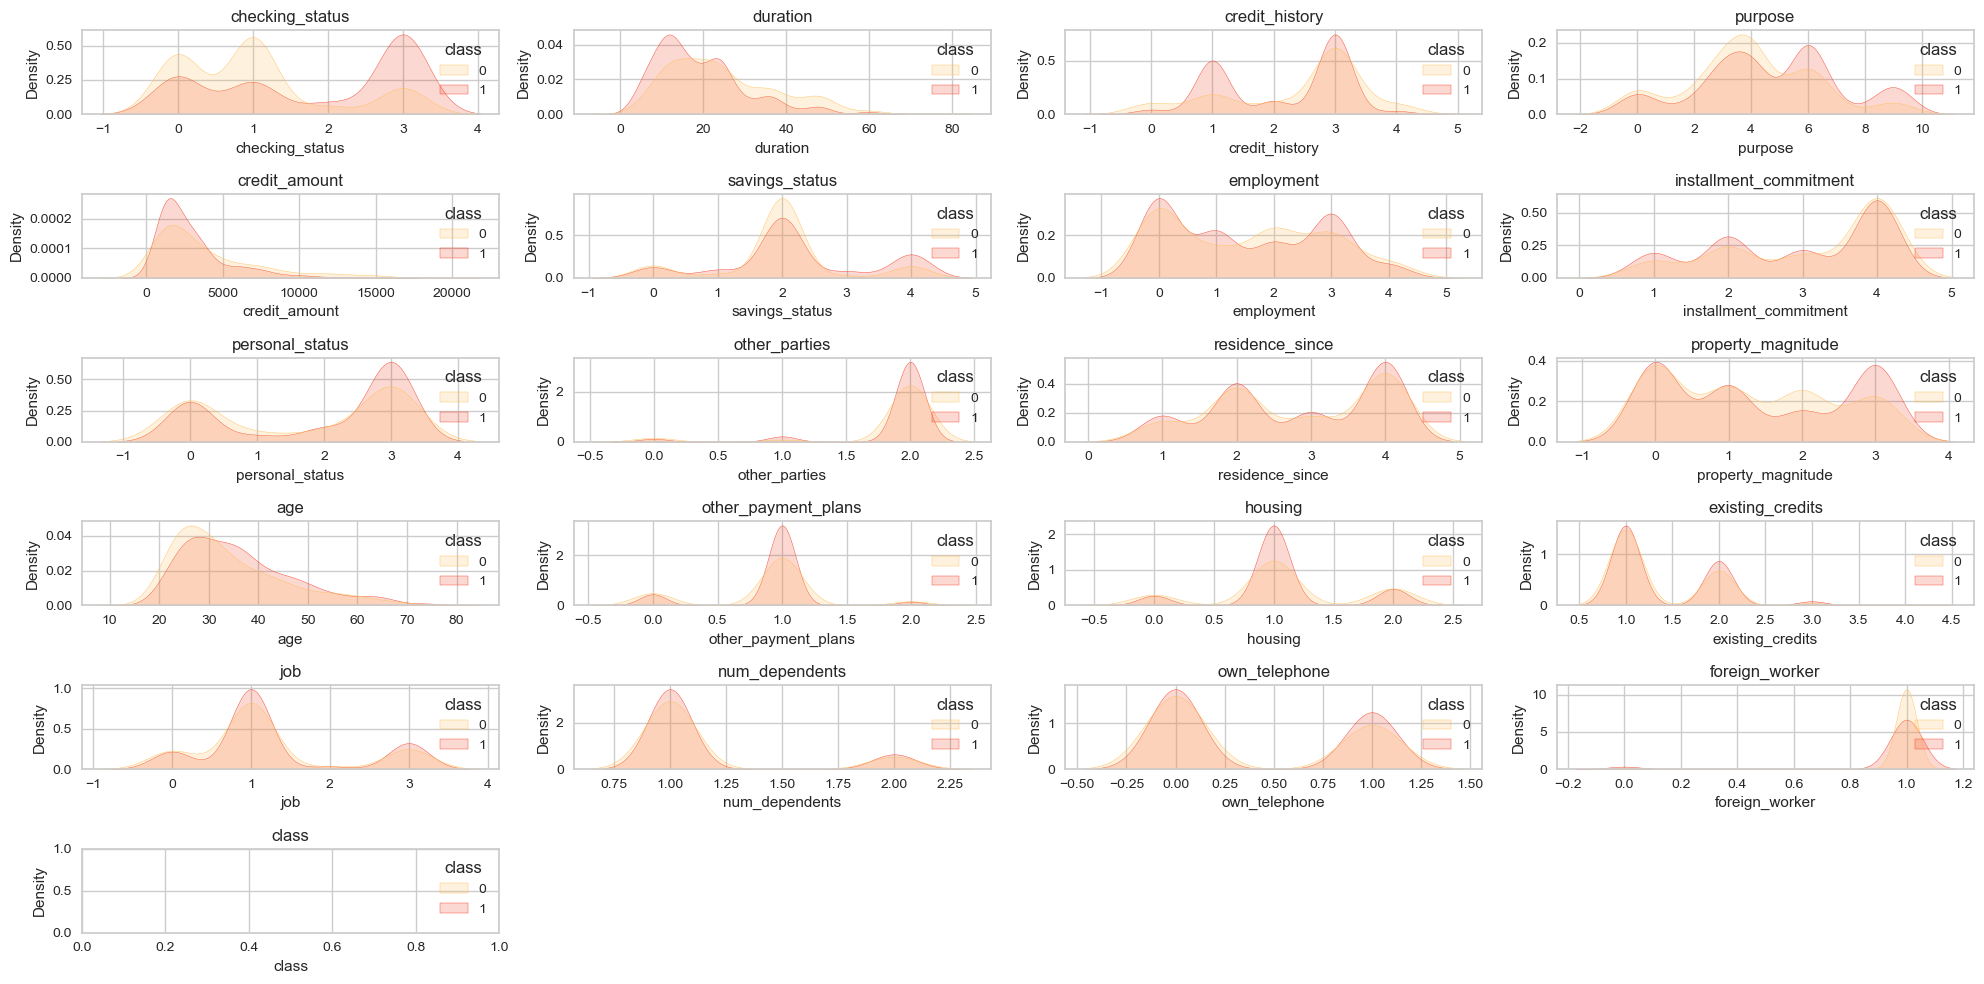

In [19]:
num_cols = 4
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="class", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

plt.scatter(data.age[data.diabetes==0],
            data.bmi[data.diabetes==0],
            alpha=.5)

plt.scatter(data.age[data.diabetes==1],
            data.bmi[data.diabetes==1],
            alpha=.5)

plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Blood Glucose Level")
plt.legend(["No Disease", "Disease"])
plt.show()

In [ ]:
sns.pairplot(data, hue='diabetes')
plt.show()

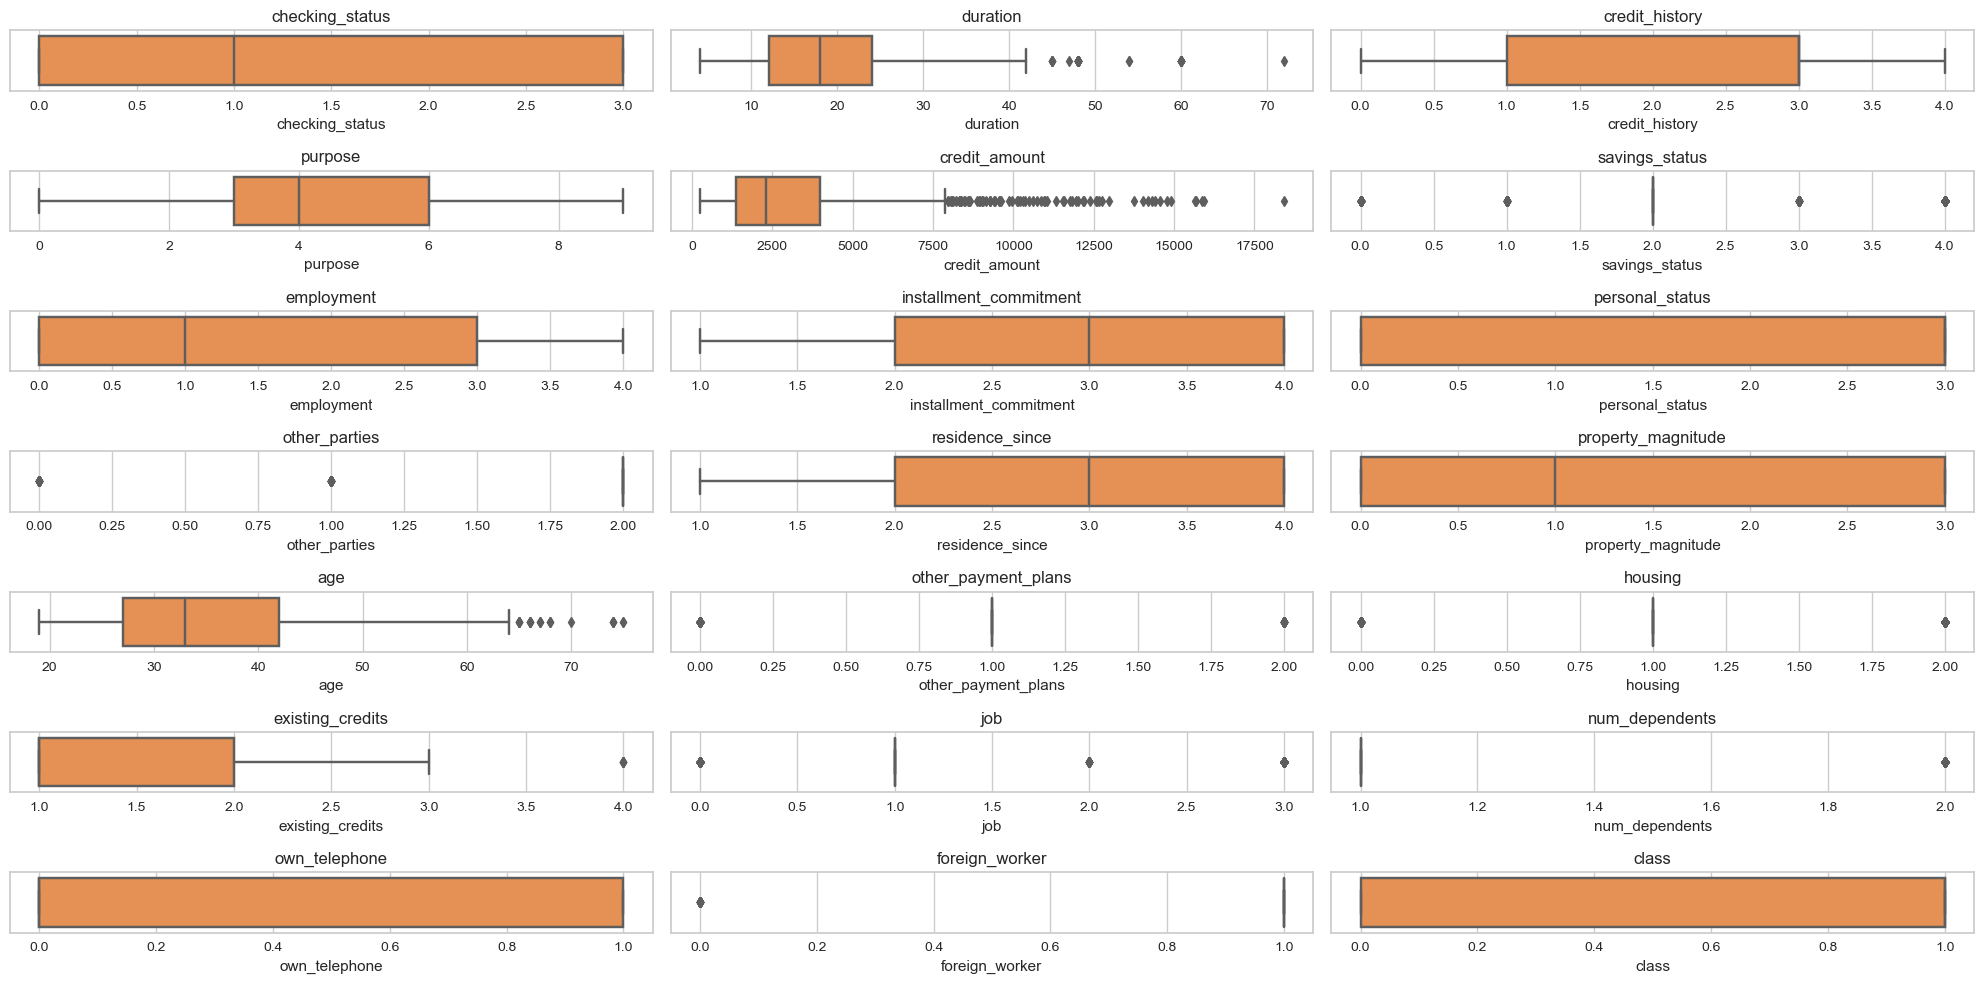

In [21]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### 3.4. Outiers Values

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.5. Data Correlation

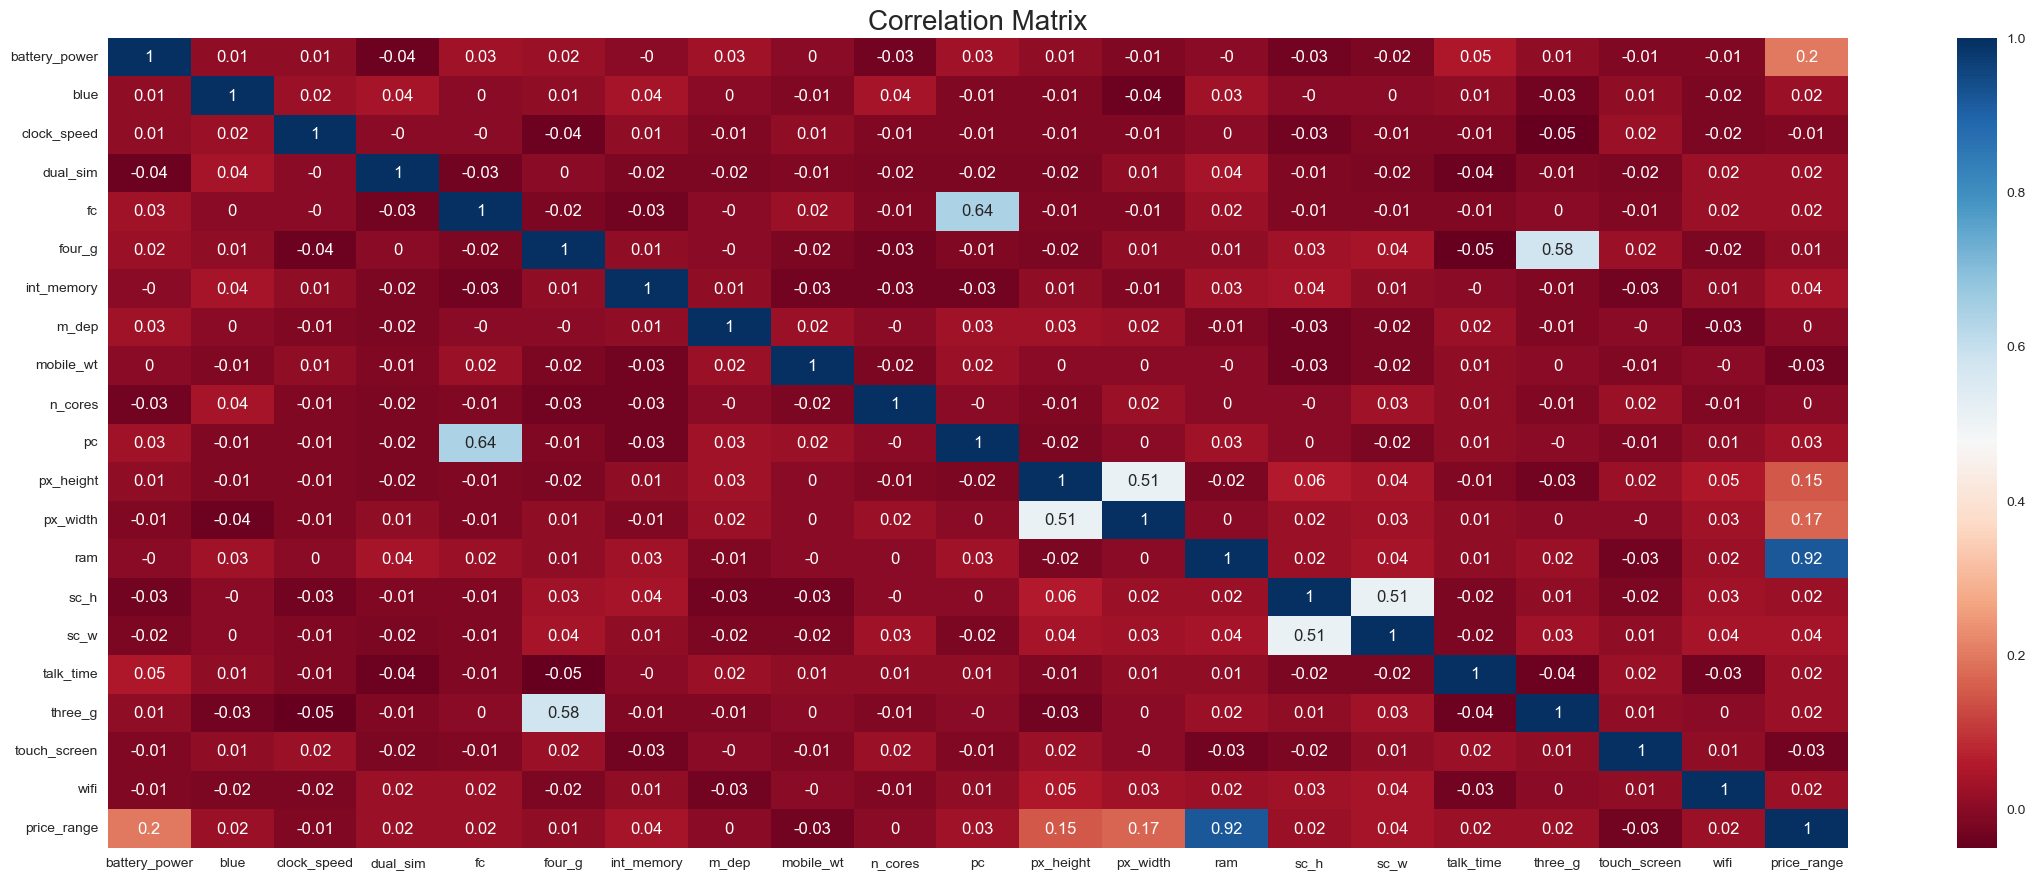

In [7]:
corr_data = data[numerical_columns].corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)
plt.show()

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


# 5 Neural Network Algoritms

In [23]:
X = data.drop(columns=['price_range']).values
Y = data['price_range']

# print(Counter(Y))
# sampling = RandomUnderSampler()
# # sampling = SMOTE()
# X, Y = sampling.fit_resample(X, Y)
# print(Counter(Y))

Y = pd.get_dummies(Y).values

# scaler = MinMaxScaler(feature_range=(0,1))
# scaler = RobustScaler()
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

label = y_train.shape[1]

(1404, 20) (1404, 4)
(396, 20) (396, 4)
(200, 20) (200, 4)


In [24]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(label, activation='softmax'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(256)))
    # model.add(Dense(32, activation='swish'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(label, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(label, activation='softmax'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              21504     
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 300,612
Trainable params: 300,612
Non-trainable params: 0
_________________________________________________________________


In [25]:
num_epoch = 50
batch_size = 32

history = model.fit(X_train, y_train, verbose = 1,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/50
44/44 [==============================] - 1s 10ms/step - loss: 1.3212 - accuracy: 0.3725 - val_loss: 1.2159 - val_accuracy: 0.5303
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 1.0854 - accuracy: 0.6161 - val_loss: 0.9735 - val_accuracy: 0.6187
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 0.8490 - accuracy: 0.7023 - val_loss: 0.7711 - val_accuracy: 0.6793
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6613 - accuracy: 0.8113 - val_loss: 0.6155 - val_accuracy: 0.7803
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 0.5212 - accuracy: 0.8789 - val_loss: 0.5088 - val_accuracy: 0.8384
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 0.4175 - accuracy: 0.9188 - val_loss: 0.4260 - val_accuracy: 0.8889
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.9466 - val_loss: 0.3687 - val_accuracy: 0.9015
Epoch 8/50
44/44 [=

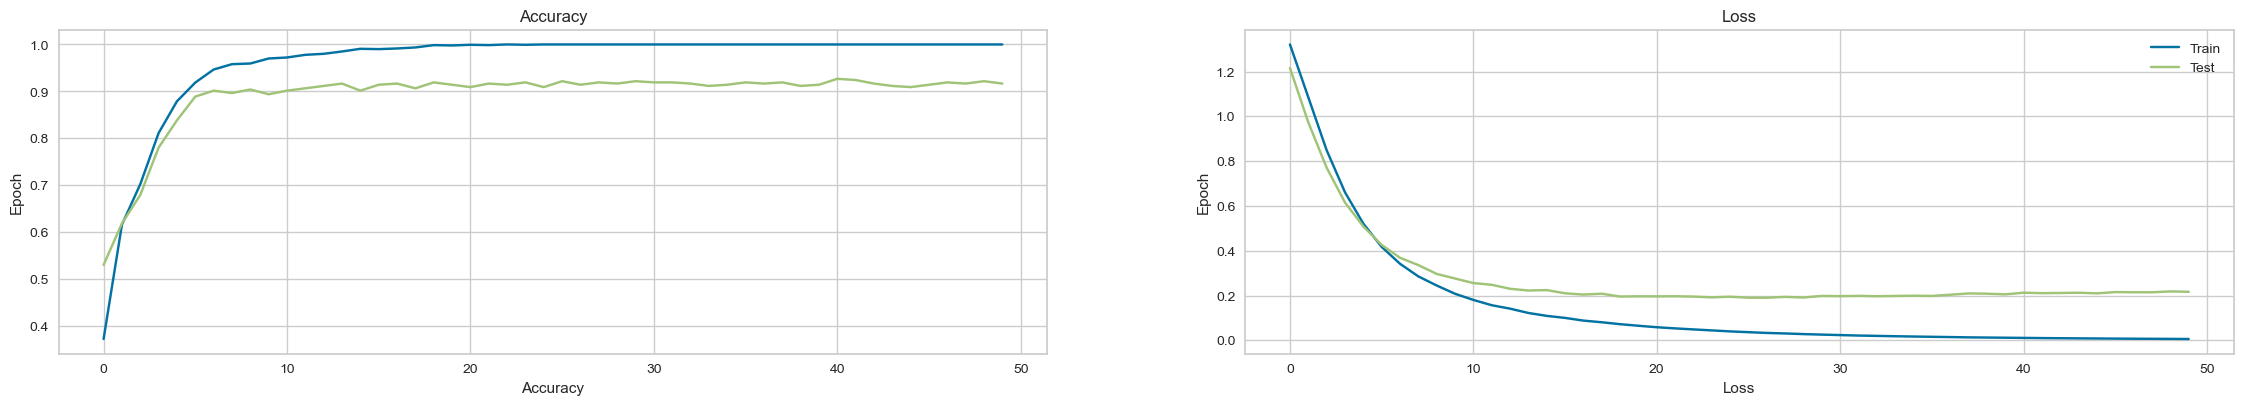

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [27]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val, verbose=0))

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        59
           1       0.96      0.96      0.96        49
           2       0.98      0.91      0.94        45
           3       0.94      0.98      0.96        47

   micro avg       0.96      0.96      0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200
 samples avg       0.96      0.96      0.96       200



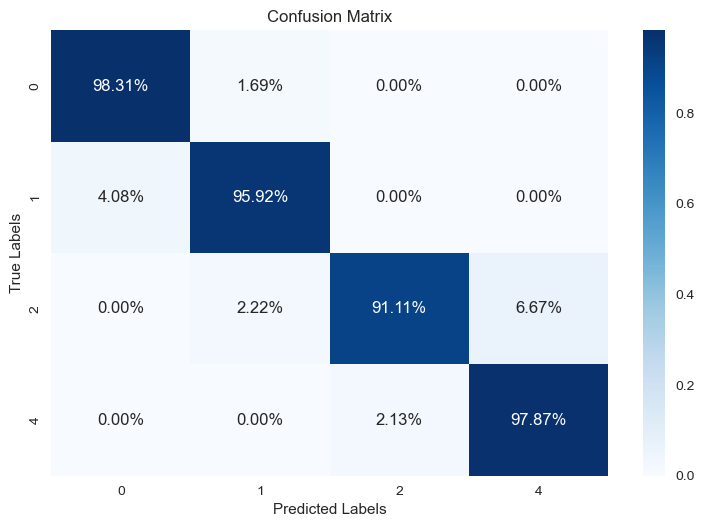

In [28]:
labels = ['0', '1', '2', '4']

y_pred = np.rint(model.predict(X_val, verbose=0).argmax(axis=1))
con_mat = confusion_matrix(y_val.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6. Supervised Learning

In [15]:
X = data.drop(columns=['price_range']).values
Y = data['price_range']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# # undersample = SMOTE()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

Y = Y.values

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(1800, 20)
(200, 20)


### 6.2 Stacking Classifier

In [16]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradient = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
pac = PassiveAggressiveClassifier(random_state=42)
linear = LogisticRegression(random_state=42)

model = StackingClassifier([
    ('bagging', bagging),
    ('adaboost', adaboost),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('decisionTree', decisionTree),
    ('histGradient', histGradient),
    ('XGB', XGB),
    # ('pac', pac),
    # ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [17]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       r...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                    

In [18]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

Train Score :  100.0 %
Test Score  :  90.5 %


In [19]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        60
           1       0.90      0.88      0.89        50
           2       0.87      0.87      0.87        45
           3       0.89      0.93      0.91        45

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.91      0.91      0.91       200



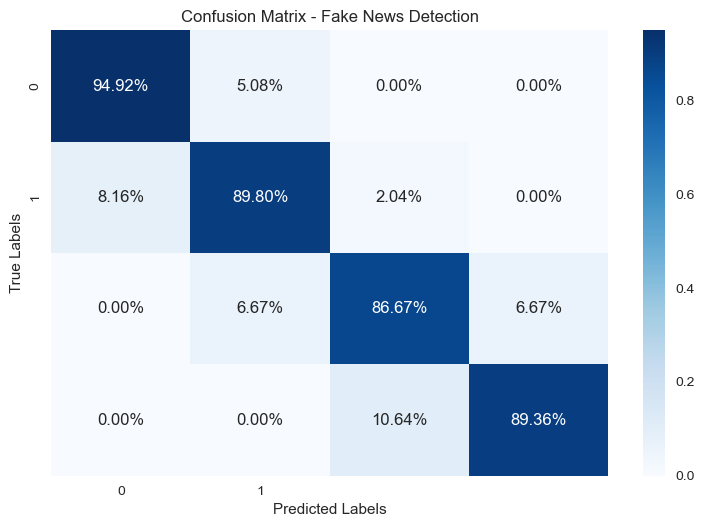

In [20]:
labels = ['0', '1', '2', '4']

y_pred = model.predict(X_test)
con_mat = confusion_matrix(y_test,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

### 6.2. Pycaret

In [72]:
s = ClassificationExperiment()
s.setup(data, target = 'diagnosis', session_id = 123)

In [73]:
best = s.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:02:22
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)

In [75]:
print(best)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)


In [76]:
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9649,0.9918,0.9688,0.9394,0.9538,0.9256,0.9258


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis,prediction_label,prediction_score
115,11.930000,21.530001,76.529999,438.600006,0.09768,0.07849,0.03328,0.02008,0.1688,0.06194,...,583.000000,0.15000,0.2399,0.15030,0.07247,0.2438,0.08541,0,0,0.99
21,9.504000,12.440000,60.340000,273.899994,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,...,314.899994,0.13240,0.1148,0.08867,0.06227,0.2450,0.07773,0,0,1.00
382,12.050000,22.719999,78.750000,447.799988,0.06935,0.10730,0.07943,0.02978,0.1203,0.06659,...,488.399994,0.08799,0.3214,0.29120,0.10920,0.2191,0.09349,0,0,0.93
136,11.710000,16.670000,74.720001,423.600006,0.10510,0.06095,0.03592,0.02600,0.1339,0.05945,...,546.700012,0.12710,0.1028,0.10460,0.06968,0.1712,0.07343,0,0,0.98
2,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,1709.000000,0.14440,0.4245,0.45040,0.24300,0.3613,0.08758,1,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,13.460000,18.750000,87.440002,551.099976,0.10750,0.11380,0.04201,0.03152,0.1723,0.06317,...,719.799988,0.16240,0.3124,0.26540,0.14270,0.3518,0.08665,0,0,0.74
142,11.430000,17.309999,73.660004,398.000000,0.10920,0.09486,0.02031,0.01861,0.1645,0.06562,...,503.000000,0.14130,0.1792,0.07708,0.06402,0.2584,0.08096,0,0,1.00
238,14.220000,27.850000,92.550003,623.900024,0.08223,0.10390,0.11030,0.04408,0.1342,0.06129,...,764.000000,0.10810,0.2426,0.30640,0.08219,0.1890,0.07796,0,0,0.62
106,11.640000,18.330000,75.169998,412.500000,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,521.700012,0.16880,0.2660,0.28730,0.12180,0.2806,0.09097,0,0,0.89


In [78]:
model = s.create_model('et')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:07:18
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9500,0.9853,0.8667,1.0000,0.9286,0.8904,0.8958
2,0.9250,1.0000,0.8000,1.0000,0.8889,0.8333,0.8452
3,0.9500,1.0000,0.8667,1.0000,0.9286,0.8904,0.8958
4,0.9750,1.0000,0.9333,1.0000,0.9655,0.9459,0.9473
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9500,0.9960,0.9333,0.9333,0.9333,0.8933,0.8933
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9487,0.9800,0.9286,0.9286,0.9286,0.8886,0.8886


In [79]:
X = data.drop(columns=['diagnosis']).values
Y = data['diagnosis']

<Axes: >

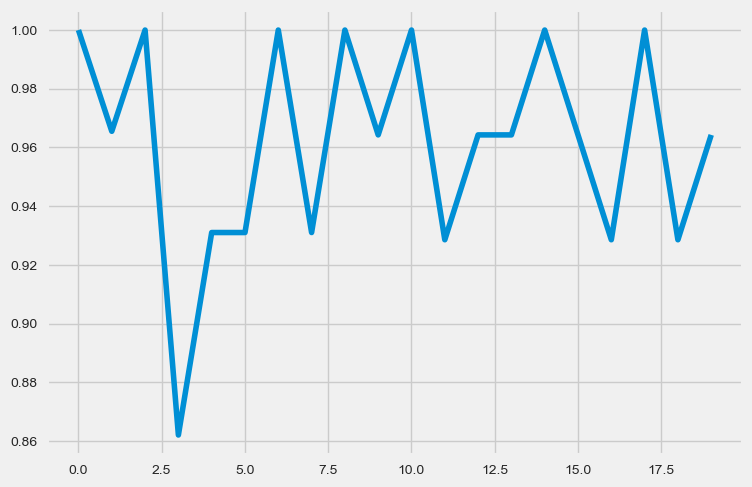

In [85]:
scores = cross_val_score(model, X, Y, cv=20)
sns.lineplot(scores)

In [82]:
preds = s.predict_model(model)
preds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9649,0.9918,0.9688,0.9394,0.9538,0.9256,0.9258


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis,prediction_label,prediction_score
115,11.930000,21.530001,76.529999,438.600006,0.09768,0.07849,0.03328,0.02008,0.1688,0.06194,...,583.000000,0.15000,0.2399,0.15030,0.07247,0.2438,0.08541,0,0,0.99
21,9.504000,12.440000,60.340000,273.899994,0.10240,0.06492,0.02956,0.02076,0.1815,0.06905,...,314.899994,0.13240,0.1148,0.08867,0.06227,0.2450,0.07773,0,0,1.00
382,12.050000,22.719999,78.750000,447.799988,0.06935,0.10730,0.07943,0.02978,0.1203,0.06659,...,488.399994,0.08799,0.3214,0.29120,0.10920,0.2191,0.09349,0,0,0.93
136,11.710000,16.670000,74.720001,423.600006,0.10510,0.06095,0.03592,0.02600,0.1339,0.05945,...,546.700012,0.12710,0.1028,0.10460,0.06968,0.1712,0.07343,0,0,0.98
2,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,1709.000000,0.14440,0.4245,0.45040,0.24300,0.3613,0.08758,1,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,13.460000,18.750000,87.440002,551.099976,0.10750,0.11380,0.04201,0.03152,0.1723,0.06317,...,719.799988,0.16240,0.3124,0.26540,0.14270,0.3518,0.08665,0,0,0.74
142,11.430000,17.309999,73.660004,398.000000,0.10920,0.09486,0.02031,0.01861,0.1645,0.06562,...,503.000000,0.14130,0.1792,0.07708,0.06402,0.2584,0.08096,0,0,1.00
238,14.220000,27.850000,92.550003,623.900024,0.08223,0.10390,0.11030,0.04408,0.1342,0.06129,...,764.000000,0.10810,0.2426,0.30640,0.08219,0.1890,0.07796,0,0,0.62
106,11.640000,18.330000,75.169998,412.500000,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,521.700012,0.16880,0.2660,0.28730,0.12180,0.2806,0.09097,0,0,0.89


In [84]:
pred = (abs(preds['diagnosis'] - preds['prediction_label'])).sum()

print(f'{pred} / {preds.shape[0]} : {round(pred/preds.shape[0]*100, 2)} % (False Predictions)')

6 / 171 : 3.51 % (False Predictions)
